# 2. EM algorithm

## Download Data

In [1]:
# wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !gunzip train-images-idx3-ubyte.gz

# !wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !gunzip train-labels-idx1-ubyte.gz

# !wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !gunzip t10k-images-idx3-ubyte.gz

# !wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
# !gunzip t10k-labels-idx1-ubyte.gz

## Load Data & Binning

train_num: 60000 test_num: 10000


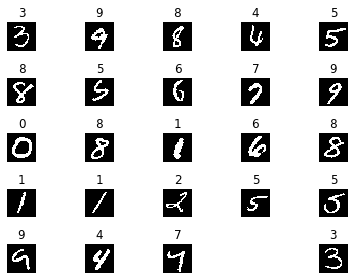

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_img = 'train-images-idx3-ubyte'
train_label = 'train-labels-idx1-ubyte'
test_img = 't10k-images-idx3-ubyte'
test_label = 't10k-labels-idx1-ubyte'



def load_MNIST(img_path, label_path):
    """
    # Input
        img_path: MNIST images path. e.g. train-images-idx3-ubyte
        label_path: MNIST label path. e.g. train-labels-idx1-ubyte
    
    # Return
        train_x: shape(n, row, col)
        train_y: shape(n,)
    """
    img_file = open(img_path, 'rb')
    label_file = open(label_path, 'rb')

    img_file.read(4) # magic number 0~3 offset
    n = int.from_bytes(img_file.read(4), byteorder='big') # number of images 4~7 offset
    row = int.from_bytes(img_file.read(4), byteorder='big') # 8~11 offset rows
    col = int.from_bytes(img_file.read(4), byteorder='big') # 12~15 offset cols
    label_file.read(8) # skip label's magic number & number of items
    train_x = np.zeros((n, row, col), dtype='uint8')
    train_y = np.zeros(n, dtype='uint8')
    
    # 1 offset per a pixel value
    for i in range(n):
        for j in range(row):
            for k in range(col):
                pixel_value = int.from_bytes(img_file.read(1), byteorder='big')
                if pixel_value > 127:
                    train_x[i,j,k] = 1
                else:
                    train_x[i,j,k] = 0
        train_y[i] = int.from_bytes(label_file.read(1), byteorder='big')

    return (train_x,train_y)


train_x, train_y = load_MNIST(train_img, train_label)
test_x, test_y = load_MNIST(test_img, test_label)

print(f'train_num: {len(train_x)} test_num: {len(test_x)}')

# Visualization 
mask = np.random.choice(60000, 25, replace=False)
example_img = train_x[mask]
example_label = train_y[mask]
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(example_label[i])
    plt.axis('off')
    plt.imshow(example_img[i], cmap="gray")
    plt.tight_layout()

## Initialization

In [3]:
def Initial_lambda(train_y):
    """
    # Input
        train_y: labels (n,)
    # Return
        Lambda: probability of each classes (10,1)
    """    
    # Random
#     n_class = len(np.unique(train_y))
#     Lambda = np.random.rand(n_class, 1)
#     Lambda = Lambda / np.sum(Lambda)
#     return Lambda
    
    # Uniform Distribution
    n_class = len(np.unique(train_y))
    Lambda = np.ones((n_class,1)) / n_class
    return Lambda

def Initial_prob(train_x, train_y):
    """
    # Input
        train_x: Images (n,28,28)
        train_y: labels (n,)
    # Return
        prob: probaility of each pixel in class (10,28*28)
    """    
    n, h, w = train_x.shape
    n_class = len(np.unique(train_y))
    prob = np.random.rand(n_class, h*w)
    return prob

Lambda = Initial_lambda(train_y)
prob = Initial_prob(train_x, train_y)

## EM Algorithm

$P\left(X | P_{0}, P_{1}, w_{i}, \lambda\right)$
$=\prod_{i=1}^{n}\left(\lambda P_{0}^{x_{i}}\left(1-P_{0}\right)^{1-x_{i}}\right)^{w_{i}} \cdot\left((1-\lambda) P_{1}^{x_{i}}\left(1-P_{1}\right)^{1-x_{i}}\right)^{1-w_{i}}$

$\lambda=\frac{\sum_{i=1}^{n} w_{i}}{n}$

In [4]:
def Expectation(train_x, Lambda, prob):
    """
    # Input
        train_x: Images (n,28,28)
        Lambda: probaility of each classes (10,1)
        prob: probaility of each pixel in class (10,28*28)
    # Return
        W: training prediction probability (60000,10)
    """  
    n_class = len(Lambda)
    train_x = train_x.reshape(len(train_x), -1) # (60000,784)
    n, features = train_x.shape
    W = np.zeros((n, n_class)) # (60000,10)
    
    for i in range(n): # 60000
        for j in range(n_class): # 10
            W[i,j] = np.prod(train_x[i]*prob[j] + (1-train_x[i])*(1-prob[j]))
    
    # Posterior = Likelihood * Prior
    W = W*Lambda.T # (60000,10) * (1,10)

    # Normalization
    total = np.sum(W, axis=1)
    total = np.where(total==0, 1, total)
    W = W / total.reshape(-1,1) # (60000,10) / (60000,1)

    return W

def Maximization(W, train_x):
    """
    # Input
        W: training prediction probability (60000,10)
        train_x: Images (n,28,28)
    # Return
        new_Lambda: new probability of each classes (10,1)
        new_prob: new probaility of each pixel in class (10,28*28)
    """  
    train_x = train_x.reshape(len(train_x), -1) # (60000,784)
    new_Lambda = np.sum(W, axis=0) / len(W) # (10,)
    
    # Normalize W
    total = np.sum(W, axis=0) # (10,)
    total = np.where(total==0, 1, total)
    W = W / total # (60000,10)
    new_prob = W.T @ train_x # (10,60000) @ (60000,784)
    return new_Lambda, new_prob

## Ground Truth Probability

In [5]:
def GroundTruth_Pixel_Prob(train_x, train_y):
    """
    # Input
        train_x: Images (n,28,28)
        train_y: labels (n,)
    # Return
        prob: Ground Truth probaility of each pixel in class (10,28*28)
    """  
    n, row, col = train_x.shape
    features = train_x.reshape(n, -1)
    distribution = np.zeros((10, row*col))
    for i in range(n):
        categories = train_y[i]
        for j in range(row*col):
            if features[i,j]==1:
                distribution[categories,j] += 1
                
    labels = np.zeros((10, 1))
    for x in train_y:
        labels[x] += 1

    #normalized
    distribution = distribution / labels

    return distribution

## Visualization

In [6]:
def Imageination_Number(prob, new_order):
    """
    # Input
        train_x: Images (n,28,28)
        new_order: correct order of numbers (10,)
    """   
    prob = np.where(prob>0.5, 1, 0)
    prob = prob.reshape(10,28,28)
    plt.figure(figsize=(10,20))
    for i in range(10):
        plt.subplot(10,1,i+1)
        plt.title(f'class {i}:')
        plt.imshow(prob[new_order[i]], cmap='gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()
    

from scipy.optimize import linear_sum_assignment

def Compare_Hungarian_algorithm(prob, gt_prob):
    """
    # Input
        prob: probaility of each pixel in class (10,28*28)
        gtprob: Ground Truth probaility of each pixel in class (10,28*28)
    # Return
        order: correct order of numbers (10,)
    """  
    loss = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            loss[i,j] = np.sum(abs(gt_prob[i] - prob[j]))

    order = linear_sum_assignment(loss)

    return order
   

In [7]:
# def Imageination_Number(prob, new_order):
#     """
#     Visualization
#     # Input
#         likelihood: shape(10, 28*28, 32 or 256)
#     """    

#     print("")
#     for i in range(10):
#         print(f'class {i}:')
#         for j in range(28):
#             for k in range(28):
#                 value = prob[new_order[i],j*28+k]
#                 if value > 0.5:
#                     print("1", end='')
#                 else:
#                     print("0", end='')
#             print("")
#         print("")

# def Compare(prob, gt_prob):
#     min_loss = np.inf
#     drop_num = np.nan
#     order = []
    
#     for i in range(10):
#         for j in range(10):
#             loss = np.sum(abs(gt_prob[i] - prob[j]))
#             if loss < min_loss:
#                 min_loss = loss
#                 drop_num = j
                
#         order.append(drop_num)
#         min_loss = np.inf
#     return np.array(order) 

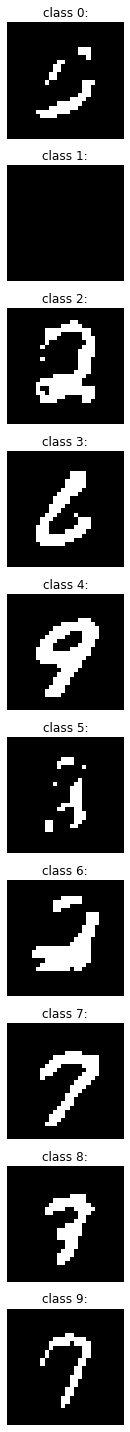

No. of Iteration: 1, Difference: 3258.344278062365
λ: [7.65556219e-03 5.42120953e-03 5.24548114e-05 2.21752197e-03
 8.05752755e-02 3.50372553e-02 0.00000000e+00 2.38668192e-03
 4.62250338e-02 1.57900502e-03]


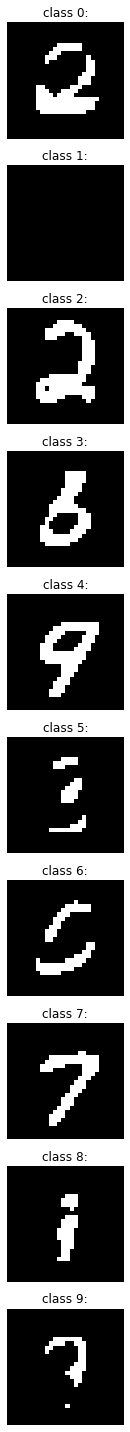

No. of Iteration: 2, Difference: 245.35367632320404
λ: [4.77755894e-02 8.65534366e-02 8.33288723e-05 1.82008474e-01
 2.61646531e-01 1.99047560e-01 0.00000000e+00 5.47932603e-02
 1.41333082e-01 2.40754056e-02]


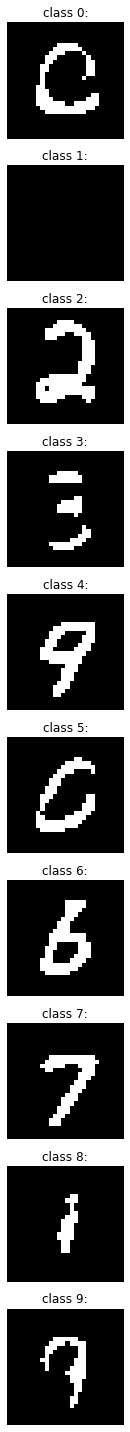

No. of Iteration: 3, Difference: 111.69909154732744
λ: [5.70080534e-02 1.08193475e-01 8.33333333e-05 1.50884442e-01
 2.55688364e-01 1.72241330e-01 0.00000000e+00 6.66645530e-02
 1.37516030e-01 4.90370857e-02]


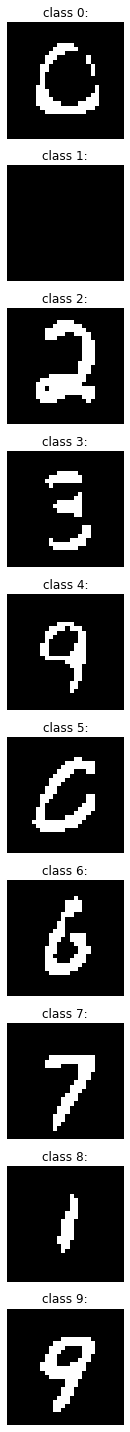

No. of Iteration: 4, Difference: 59.585471434018345
λ: [6.44898996e-02 1.07633990e-01 8.33333333e-05 1.47818996e-01
 2.28047977e-01 1.61645738e-01 0.00000000e+00 8.12104755e-02
 1.36365679e-01 7.00205782e-02]


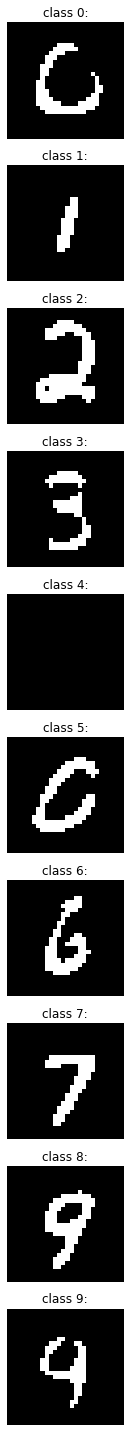

No. of Iteration: 5, Difference: 37.88904971336168
λ: [6.83652127e-02 1.04212859e-01 8.33333333e-05 1.45259133e-01
 2.05238140e-01 1.57261373e-01 0.00000000e+00 9.17381416e-02
 1.37341497e-01 8.78169782e-02]


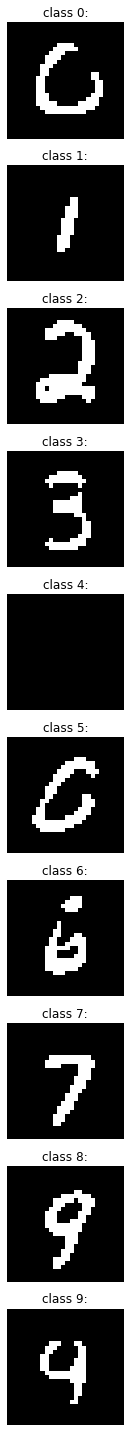

No. of Iteration: 6, Difference: 25.947831093826085
λ: [7.06415621e-02 1.00361153e-01 8.33333333e-05 1.44321315e-01
 1.89285006e-01 1.55955919e-01 0.00000000e+00 9.58771393e-02
 1.39866805e-01 1.00924434e-01]


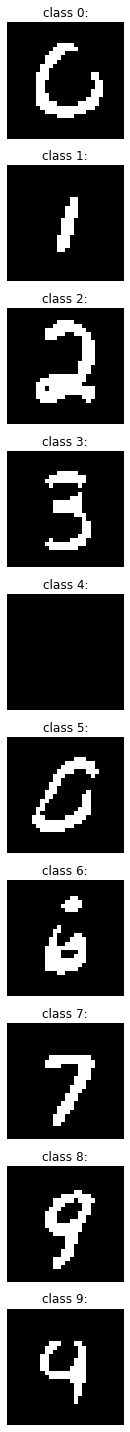

No. of Iteration: 7, Difference: 19.551770694971925
λ: [7.22875485e-02 9.69869852e-02 8.33333333e-05 1.44107943e-01
 1.79401304e-01 1.55976765e-01 0.00000000e+00 9.68629151e-02
 1.42719994e-01 1.08889878e-01]


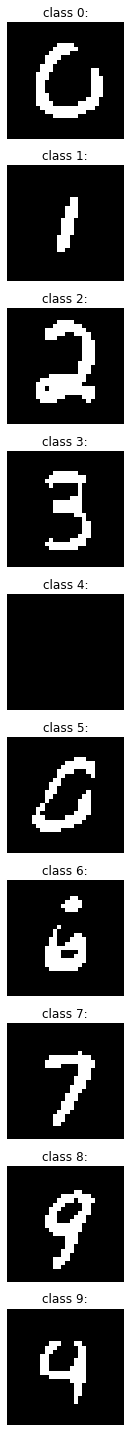

No. of Iteration: 8, Difference: 17.72159633208531
λ: [7.36282836e-02 9.35164828e-02 8.33333333e-05 1.44699641e-01
 1.73256239e-01 1.56296033e-01 0.00000000e+00 9.68522128e-02
 1.45523083e-01 1.13461358e-01]


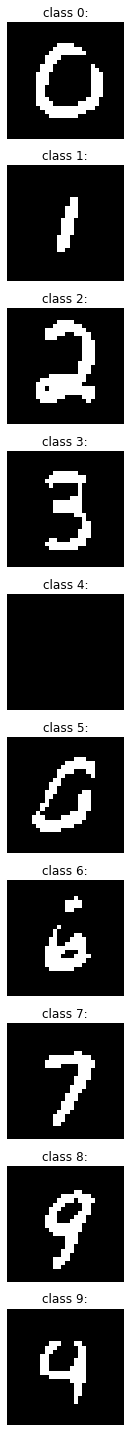

No. of Iteration: 9, Difference: 16.92002995789902
λ: [7.47168265e-02 9.06218951e-02 8.33333333e-05 1.45835933e-01
 1.69112489e-01 1.56368703e-01 0.00000000e+00 9.55965438e-02
 1.48634763e-01 1.16346179e-01]


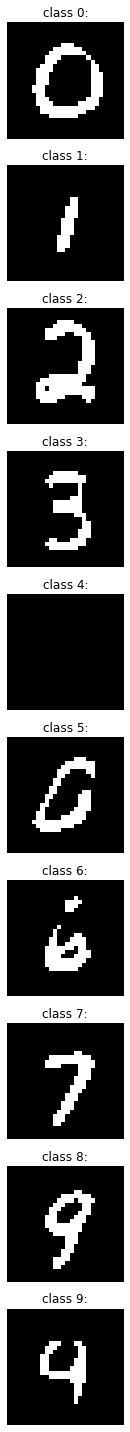

No. of Iteration: 10, Difference: 16.159347723209343
λ: [7.56851496e-02 8.82690661e-02 8.33333333e-05 1.47109844e-01
 1.65690568e-01 1.56302239e-01 0.00000000e+00 9.35948225e-02
 1.52368050e-01 1.18213593e-01]


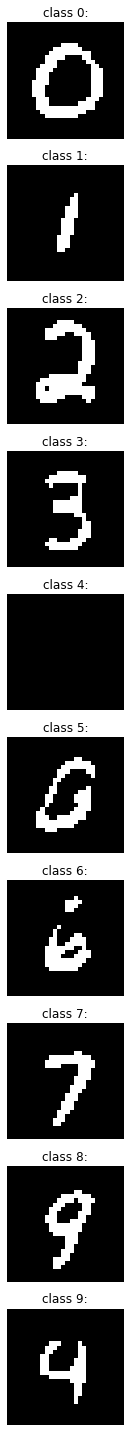

No. of Iteration: 11, Difference: 15.350912873131394
λ: [7.65826823e-02 8.66317905e-02 8.33333333e-05 1.48000138e-01
 1.62575179e-01 1.56308544e-01 0.00000000e+00 9.13394805e-02
 1.56380048e-01 1.19415471e-01]


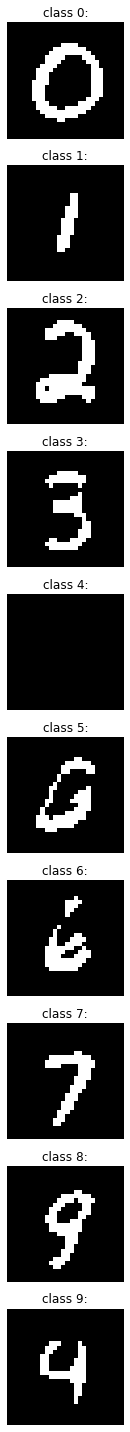

No. of Iteration: 12, Difference: 14.814854887841353
λ: [7.74287052e-02 8.50289916e-02 8.33333333e-05 1.48791028e-01
 1.59925716e-01 1.56276739e-01 0.00000000e+00 8.92563698e-02
 1.60207533e-01 1.20318250e-01]


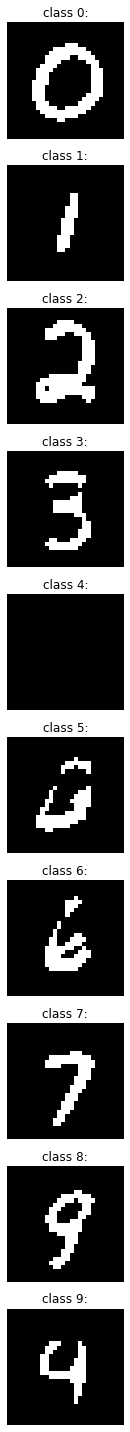

No. of Iteration: 13, Difference: 14.239382533658267
λ: [7.82975504e-02 8.43282988e-02 8.33333333e-05 1.49314836e-01
 1.57834325e-01 1.56093970e-01 0.00000000e+00 8.71963844e-02
 1.63013155e-01 1.21154813e-01]


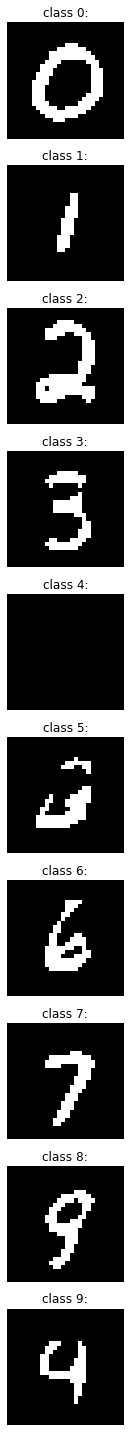

No. of Iteration: 14, Difference: 14.60178002037156
λ: [7.93066524e-02 8.41625040e-02 8.33333333e-05 1.49481187e-01
 1.55992509e-01 1.55923126e-01 0.00000000e+00 8.49773774e-02
 1.65486617e-01 1.21903359e-01]


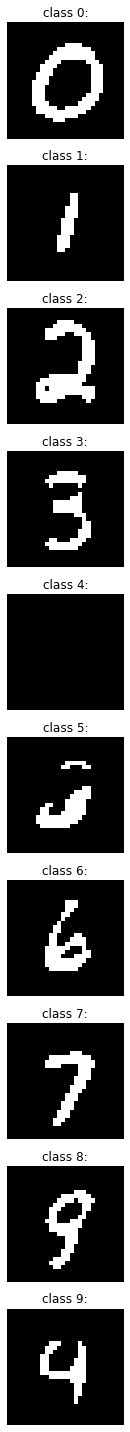

No. of Iteration: 15, Difference: 14.914262858492444
λ: [8.05879553e-02 8.36228936e-02 8.33333333e-05 1.49512946e-01
 1.54439766e-01 1.55620189e-01 0.00000000e+00 8.26220673e-02
 1.68396865e-01 1.22430651e-01]


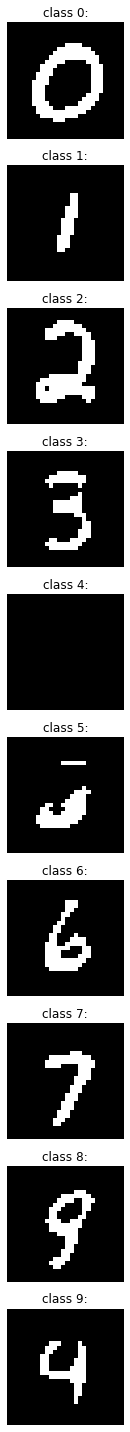

No. of Iteration: 16, Difference: 14.739443565781118
λ: [8.22159328e-02 8.25420132e-02 8.33333333e-05 1.49491613e-01
 1.53279908e-01 1.55376581e-01 0.00000000e+00 7.97844261e-02
 1.72022398e-01 1.22520461e-01]


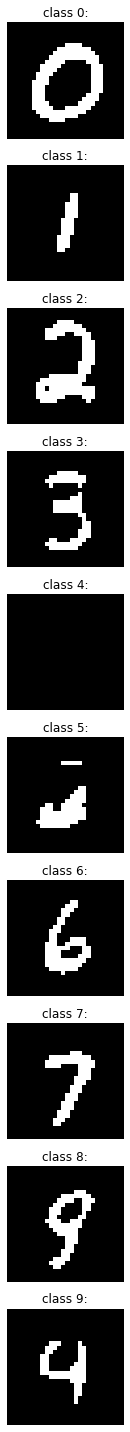

No. of Iteration: 17, Difference: 15.826632916128748
λ: [8.41461848e-02 8.18097413e-02 8.33333333e-05 1.49541674e-01
 1.52488960e-01 1.54849984e-01 0.00000000e+00 7.56044719e-02
 1.76544900e-01 1.22247418e-01]


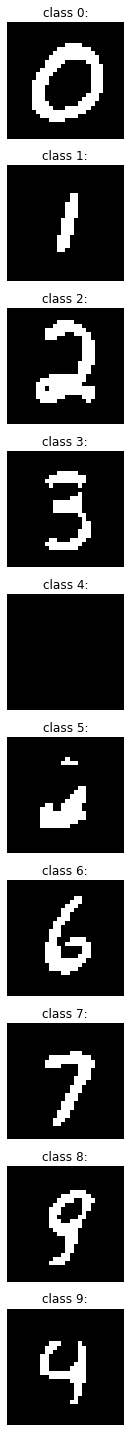

No. of Iteration: 18, Difference: 15.562976657392612
λ: [8.64329122e-02 8.18357003e-02 8.33333333e-05 1.49517742e-01
 1.52059671e-01 1.54409747e-01 0.00000000e+00 7.09685609e-02
 1.80842149e-01 1.21166852e-01]


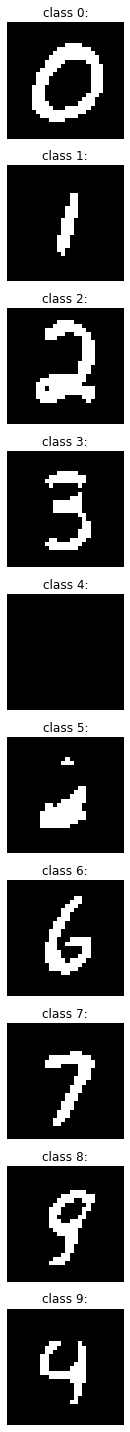

No. of Iteration: 19, Difference: 14.638686377493496
λ: [8.93157370e-02 8.23590200e-02 8.33333333e-05 1.49632603e-01
 1.51912742e-01 1.54414705e-01 0.00000000e+00 6.63989135e-02
 1.84376881e-01 1.18822732e-01]


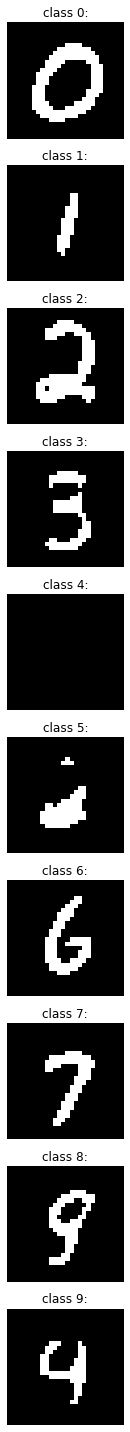

No. of Iteration: 20, Difference: 13.576652893408735
λ: [9.28645963e-02 8.30774564e-02 8.33333333e-05 1.49744963e-01
 1.51914747e-01 1.54511423e-01 0.00000000e+00 6.30892692e-02
 1.86594917e-01 1.15435961e-01]


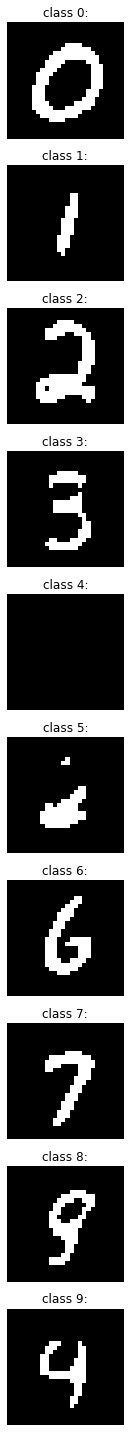

No. of Iteration: 21, Difference: 10.83312782052583
λ: [9.70485883e-02 8.36589633e-02 8.33333333e-05 1.49957190e-01
 1.51915741e-01 1.54569421e-01 0.00000000e+00 6.18084949e-02
 1.87035866e-01 1.11239070e-01]


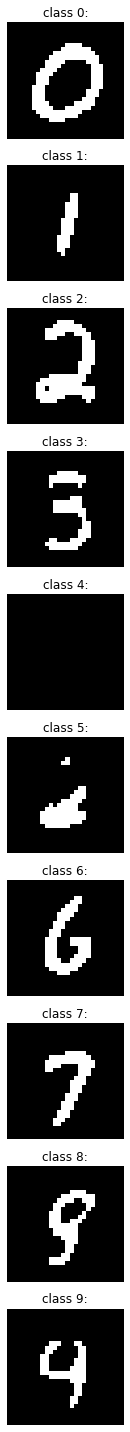

No. of Iteration: 22, Difference: 9.159820729550061
λ: [1.02094210e-01 8.39500522e-02 8.33333333e-05 1.49988086e-01
 1.51872925e-01 1.54509386e-01 0.00000000e+00 6.16962837e-02
 1.86758619e-01 1.06363770e-01]


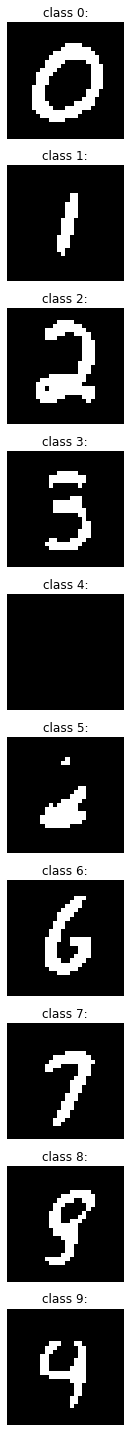

No. of Iteration: 23, Difference: 8.516186262505506
λ: [1.07999574e-01 8.39395996e-02 8.33333333e-05 1.49936174e-01
 1.51748645e-01 1.54172096e-01 0.00000000e+00 6.22724626e-02
 1.86154415e-01 1.01010368e-01]


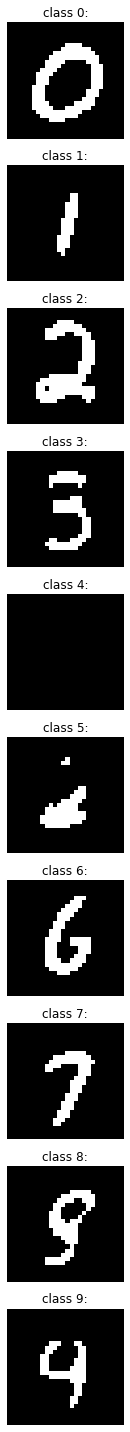

No. of Iteration: 24, Difference: 8.612535069282462
λ: [1.14353785e-01 8.38636496e-02 8.33333333e-05 1.49611282e-01
 1.51574295e-01 1.53576374e-01 0.00000000e+00 6.30153384e-02
 1.85619610e-01 9.56190007e-02]


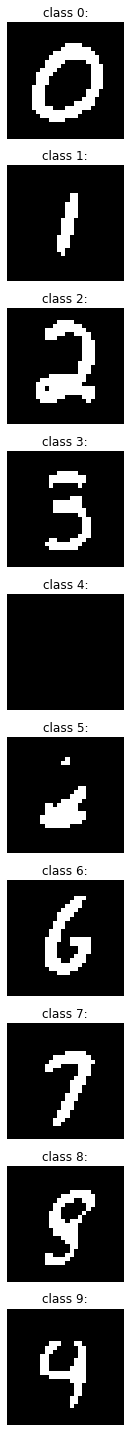

No. of Iteration: 25, Difference: 8.107844081147523
λ: [1.19946109e-01 8.37127837e-02 8.33333333e-05 1.48896957e-01
 1.51240808e-01 1.52629485e-01 0.00000000e+00 6.43040797e-02
 1.84823997e-01 9.16791137e-02]


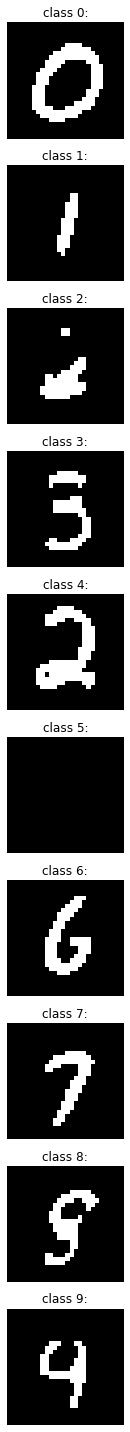

No. of Iteration: 26, Difference: 7.463938047760744
λ: [1.24335080e-01 8.34249876e-02 8.33333333e-05 1.47959795e-01
 1.50876749e-01 1.51631972e-01 0.00000000e+00 6.59889525e-02
 1.84080408e-01 8.89353891e-02]


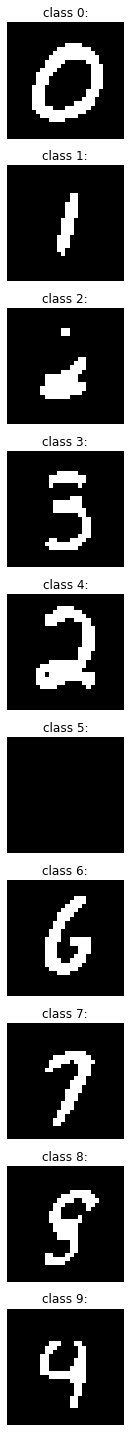

No. of Iteration: 27, Difference: 6.176734918392868
λ: [1.27421828e-01 8.30849284e-02 8.33333333e-05 1.47013332e-01
 1.50568522e-01 1.50736752e-01 0.00000000e+00 6.78547202e-02
 1.83365908e-01 8.71873425e-02]


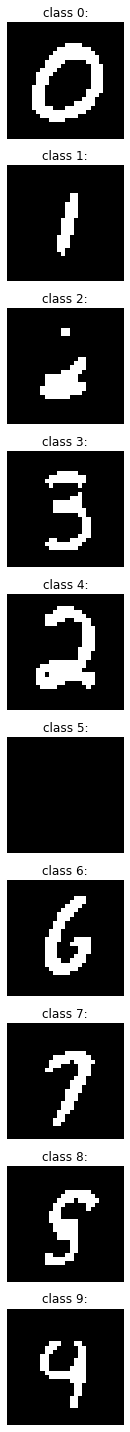

No. of Iteration: 28, Difference: 5.179195701989168
λ: [1.29402916e-01 8.26609824e-02 8.33333333e-05 1.46136220e-01
 1.50295100e-01 1.50133377e-01 0.00000000e+00 6.98262643e-02
 1.82590367e-01 8.61881061e-02]


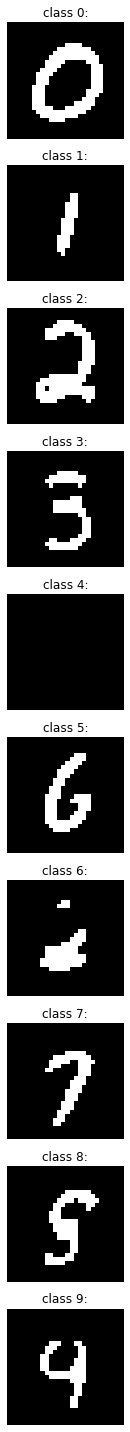

No. of Iteration: 29, Difference: 4.404703832729459
λ: [1.30611653e-01 8.22311742e-02 8.33333333e-05 1.45245446e-01
 1.50065750e-01 1.49749810e-01 0.00000000e+00 7.18508068e-02
 1.81770186e-01 8.57085082e-02]


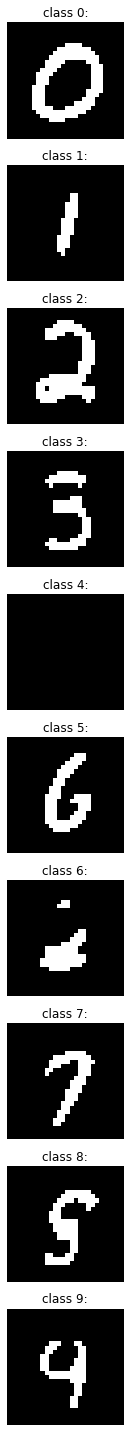

No. of Iteration: 30, Difference: 3.582759209714273
λ: [1.31347512e-01 8.18580708e-02 8.33333333e-05 1.44480901e-01
 1.49904561e-01 1.49489240e-01 0.00000000e+00 7.38139657e-02
 1.80858305e-01 8.54807789e-02]


In [8]:
gt_prob = GroundTruth_Pixel_Prob(train_x, train_y)

loss = np.inf
epislon = 1e-1
Max_iteration = 30
iteration = 0
while loss > epislon and iteration < Max_iteration:
    #E-step
    W = Expectation(train_x, Lambda, prob)

    # M-step (update)
    new_Lambda, new_prob = Maximization(W, train_x)

    # Visualization
    _, new_order = Compare_Hungarian_algorithm(new_prob, gt_prob)
    Imageination_Number(new_prob, new_order)
    
    # calculate difference
    loss = np.sum(abs(new_Lambda-Lambda)) + np.sum(abs(new_prob-prob))
    print(f'No. of Iteration: {iteration+1}, Difference: {loss}')
    print('\u03BB:',new_Lambda.reshape(1,-1)[0])
    Lambda = new_Lambda
    prob = new_prob
    iteration += 1
    


## Ground Truth Number Images

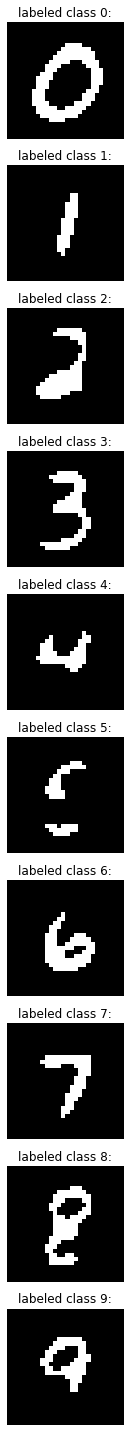

In [9]:
gt_print = np.where(gt_prob>0.5, 1, 0)
gt_print = gt_print.reshape(10,28,28)
plt.figure(figsize=(10,20))
for i in range(10):
    plt.subplot(10,1,i+1)
    plt.title(f'labeled class {i}:')
    plt.imshow(gt_print[i], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

# for i in range(10):
#     print(f'labeled class {i}:')
#     for j in range(28):
#         for k in range(28):
#             value = gt_prob[[i],j*28+k]
#             if value > 0.5:
#                 print("1", end='')
#             else:
#                 print("0", end='')
#         print("")
#     print("")

## Confusion Matrix

In [10]:
prediction = np.argmax(W, axis=1) # (60000,)
order = dict((value,idx) for idx, value in enumerate(new_order))
total_TP = 0
for i in range(10):
    TP = TN = FP = FN = 0
    for idx,p in enumerate(prediction):
        
        if order[p]==train_y[idx] and train_y[idx]==i:
            TP+=1
            total_TP+=1
        elif order[p]!=train_y[idx] and train_y[idx]!=i:
            TN+=1
        elif order[p]==train_y[idx] and train_y[idx]!=i:
            FN+=1
        else:
            FP+=1

    print(f'Confusion Matrix {i}: ')
    print(f'{"":<13}Predict number {i} Predict not number {i}')
    print(f'Is number {i}{"":8}{TP}{"":16}{FN}')
    print(f'Isn\'t number {i}{"":4}{FP}{"":16}{TN}')

    print('')
    print(f'Sensitivity (Successfully predict cluster 1): {TP/(TP+FN) if TP+FN!=0 else 0}')
    print(f'Specificity (Successfully predict cluster 2): {TN/(TN+FP) if TN+FP!=0 else 0}')
    print('\n------------------------------------------------------------\n') 
          
print(f'Total iteration to converge: {iteration}')
print(f'Total error rate: {(60000-total_TP)/60000}')

Confusion Matrix 0: 
             Predict number 0 Predict not number 0
Is number 0        4561                23079
Isn't number 0    1362                30998

Sensitivity (Successfully predict cluster 1): 0.16501447178002895
Specificity (Successfully predict cluster 2): 0.957911001236094

------------------------------------------------------------

Confusion Matrix 1: 
             Predict number 1 Predict not number 1
Is number 1        6475                21165
Isn't number 1    267                32093

Sensitivity (Successfully predict cluster 1): 0.23426193921852387
Specificity (Successfully predict cluster 2): 0.9917490729295426

------------------------------------------------------------

Confusion Matrix 2: 
             Predict number 2 Predict not number 2
Is number 2        4                27636
Isn't number 2    5954                26406

Sensitivity (Successfully predict cluster 1): 0.0001447178002894356
Specificity (Successfully predict cluster 2): 0.816007416563658